# Estimating COVID-19's $R_t$ in Real-Time

**Original author**: Kevin Systrom---April 17.

Source: 
1. https://rt.live/ (live page)
2. https://github.com/k-sys/covid-19 (notebook); 

   SHA1: cfba8cf5979da87adb7f57d6ff9ff3903d7a4f01
   


In [1]:
# notebook-specific functions: run in iteractive mode (-i) to make globals available 
%run -i rt_live_functions.py

In [2]:
# get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'retina'")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

import matplotlib
# matplotlib.use('Agg')  # Agg backend for non-interactive use with Org


In [39]:
# GLOBALS
RUN_WITH_DROPLEVEL = False

FILTERED_REGION_CODES = ['AS', 'GU', 'PR', 'VI', 'MP']

no_lockdown = [
    'North Dakota', 'ND',
    'South Dakota', 'SD',
    'Nebraska', 'NE',
    'Iowa', 'IA',
    'Arkansas','AR'
]
partial_lockdown = [
    'Utah', 'UT',
    'Wyoming', 'WY',
    'Oklahoma', 'OK',
    'Massachusetts', 'MA'
]

FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]


# Introduction

In any epidemic, $R_t$ is the measure known as the 
*effective reproduction number*. 
It's the number of people who become infected per infectious person at
time $t$. The most well-known version of this number is the basic reproduction
number: $R_0$ when $t=0$. However, $R_0$ is a single measure that does not
adapt with changes in behavior and restrictions.

As a pandemic evolves, increasing restrictions (or potential releasing of
restrictions) changes $R_t$. Knowing the current $R_t$ is essential. When
$R\gg 1$, the pandemic will spread through a large part of the population. If
$R_t<1$, the pandemic will slow quickly before it has a chance to infect many
people. The lower the $R_t$: the more manageable the situation. In general,
any $R_t<1$ means things are under control.

The value of $R_t$ helps us in two ways. 
1. It helps us understand how effective our measures have been controlling an 
   outbreak and 
2. It gives us vital information about whether we should
   increase or reduce restrictions based on our competing goals of
   economic prosperity and human safety. 
   [Well-respected epidemiologists argue](https://www.nytimes.com/2020/04/06/opinion/coronavirus-end-social-distancing.html)
   that tracking $R_t$ is the only way to manage through this crisis.

Yet, today, we don't yet use $R_t$ in this way. In fact,
the only real-time measure I've seen has been for 
[Hong Kong](https://covid19.sph.hku.hk/dashboard). 
More importantly, it is not useful to understand $R_t$ at a national
level. Instead, to manage this crisis effectively, we need a local (state,
county and/or city) granularity of $R_t$.

What follows is a solution to this problem at the US State level. It's a
modified version of a solution created by \cite{Bettencourt:08} to estimate
real-time $R_t$ using a Bayesian approach. While this paper estimates a
static $R$ value, here we introduce a process model with Gaussian noise to
estimate a time-varying $R_t$.

If you have questions, comments, or improvments feel free to get in touch:
[hello@systrom.com](mailto:hello@systrom.com). 
And if it's not entirely clear, I'm not an epidemiologist. 
At the same time, data is data, and statistics are statistics and this
is based on work by well-known epidemiologists so you can calibrate your
beliefs as you wish. In the meantime, I hope you can learn something new
as I did by reading through this example. Feel free to take this work and
apply it elsewhere – internationally or to counties in the United States.

Additionally, a huge thanks to [Frank Dellaert](http://www.twitter.com/fdellaert) who suggested the addition
of the process and to [Adam Lerer](http://www.twitter.com/adamlerer) who implemented the changes. 
Not only did I learn something new, it made the model much more responsive.


# Bettencourt & Ribeiro's Approach

Every day, we learn how many more people have COVID-19. This new case count
gives us a clue about the current value of $R_t$. We also, figure that the
value of $R_t$ today is related to the value of $R_{t-1}$ (yesterday's value)
and every previous value of $R_{t-m}$ for that matter.

With these insights, the authors use 
[Bayes' Rule](https://en.wikipedia.org/wiki/Bayes%27_theorem) 
to update their beliefs about the true value of $R_t$ based on how many new
cases have been reported each day.

This is Bayes' Theorem as we'll use it:
\begin{align*}
    \Pr(R_t\mid k) &= \frac{\Pr(k\mid R_t) \cdot \Pr(R_t)}{\Pr(k)} 
\end{align*}

This says that, having seen $k$ new cases, we believe the distribution of
$R_t$ is equal to:

- The *likelihood* of seeing $k$ new cases given $R_t$ times \dots
- The *prior* beliefs of the value of $\Pr(R_t)$ without the data \dots
- divided by the probability of seeing this many cases in general.
  
This is for a single day. To make it iterative: every day that passes, we use
yesterday's prior $\Pr(R_{t-1})$ to estimate today's prior $\Pr(R_t)$. We will
assume the distribution of $R_t$ to be a Gaussian centered around $R_{t-1}$, so 
\begin{align*}
    \Pr(R_t\mid R_{t-1}) &= \mathscr{N}(R_{t-1}, \sigma), 
\end{align*}
where $\sigma$ is a
hyperparameter (see below on how we estimate $\sigma$). So on day one:
\begin{align*}
    \Pr(R_1|k_1) &\propto \Pr(R_1)\cdot \mathscr{L}(R_1 \mid k_1)
\end{align*}
On day two:
\begin{align*}
    \Pr(R_2|k_1,k_2) 
        &\propto \Pr(R_2)\cdot \mathscr{L}(R_2|k_2) \\
        &= \sum_{R_1} {\Pr(R_1|k_1)\cdot \Pr(R_2|R_1)\cdot\mathscr{L}(R_2|k_2) }
\end{align*}
etc.


# Choosing a Likelihood Function $Pr\left(k_t\mid R_t\right)$
A likelihood function function says how likely we are to see $k$ new cases,
given a value of $R_t$.

Any time you need to model ``arrivals'' over some time
period of time, statisticians like to use the 
[Poisson Distribution](https://en.wikipedia.org/wiki/Poisson_distribution).
Given an average arrival rate of $\lambda$ new cases per day, the probability of
seeing $k$ new cases is distributed according to the Poisson distribution:
\begin{align*}
    \Pr(k\mid\lambda) &= \frac{\lambda^k e^{-\lambda}}{k!}
\end{align*}



In [4]:
# Column vector of k
k = np.arange(0, 70)[:, None]

# Different values of Lambda
lambdas = [10, 20, 30, 40]

# Evaluated the Probability Mass Function (remember: poisson is discrete)
y = sps.poisson.pmf(k, lambdas)

# Show the resulting shape
print(y.shape)


(70, 4)


> **Note**: this was a terse expression which makes it tricky. All I did was
> to make $k$ a column. By giving it a column for $k$ and a ``row'' for lambda
> it will evaluate the pmf over both and produce an array that has $k$ rows
> and lambda columns. This is an efficient way of producing many distributions
> all at once, and *you will see it used again below*!


/home/tharte/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


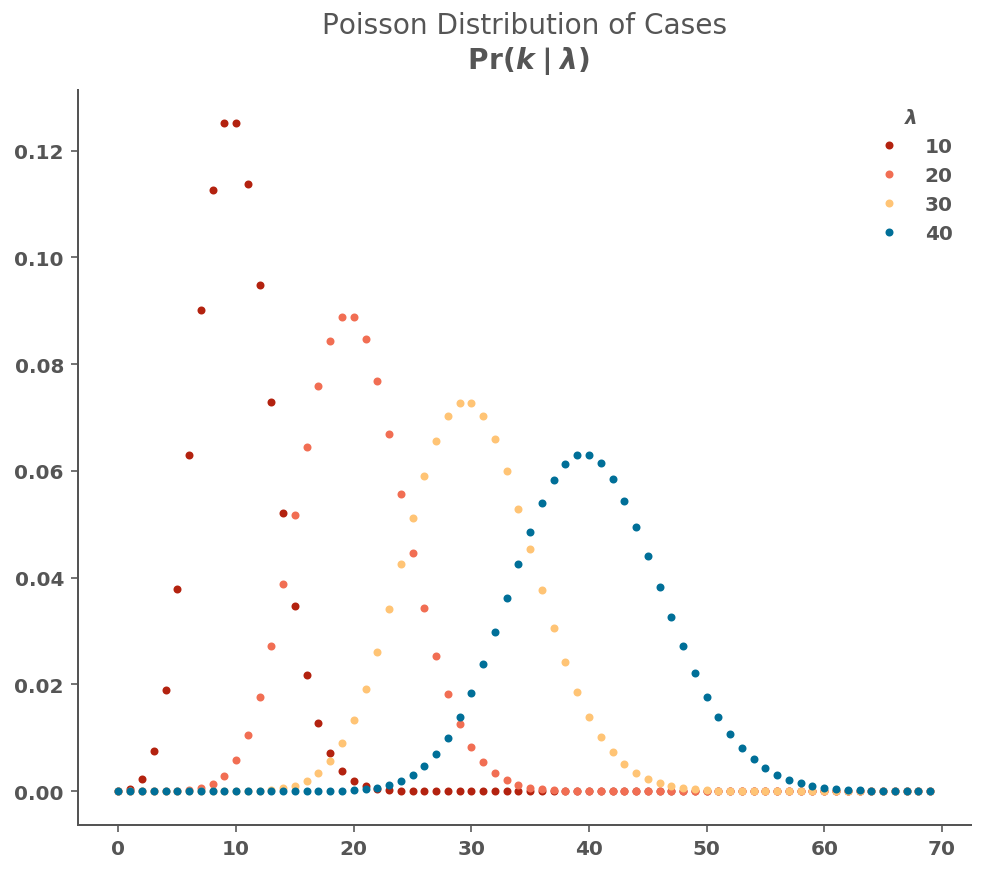

In [5]:
def plot_it():
    fig, ax = plt.subplots(figsize=(8,6.5))
    ax.set(title='Poisson Distribution of Cases\n $\Pr(k\mid\lambda)$')
    plt.plot(k, y,
    marker='o',
        markersize=3,
        lw=0
    )
    plt.legend(title="$\lambda$", labels=lambdas)
    
plot_it()

The Poisson distribution says that if you think you're going to have $\lambda$
cases per day, you'll probably get that many, plus or minus some variation
based on chance.

But in our case, we know there have been $k$ cases and we need to know what
value of $\lambda$ is most likely. In order to do this, we fix $k$ in place
while varying $\lambda$. *This is called the likelihood function.*

For example, imagine we observe $k=20$ new cases, and we want to know how
likely each $\lambda$ is:


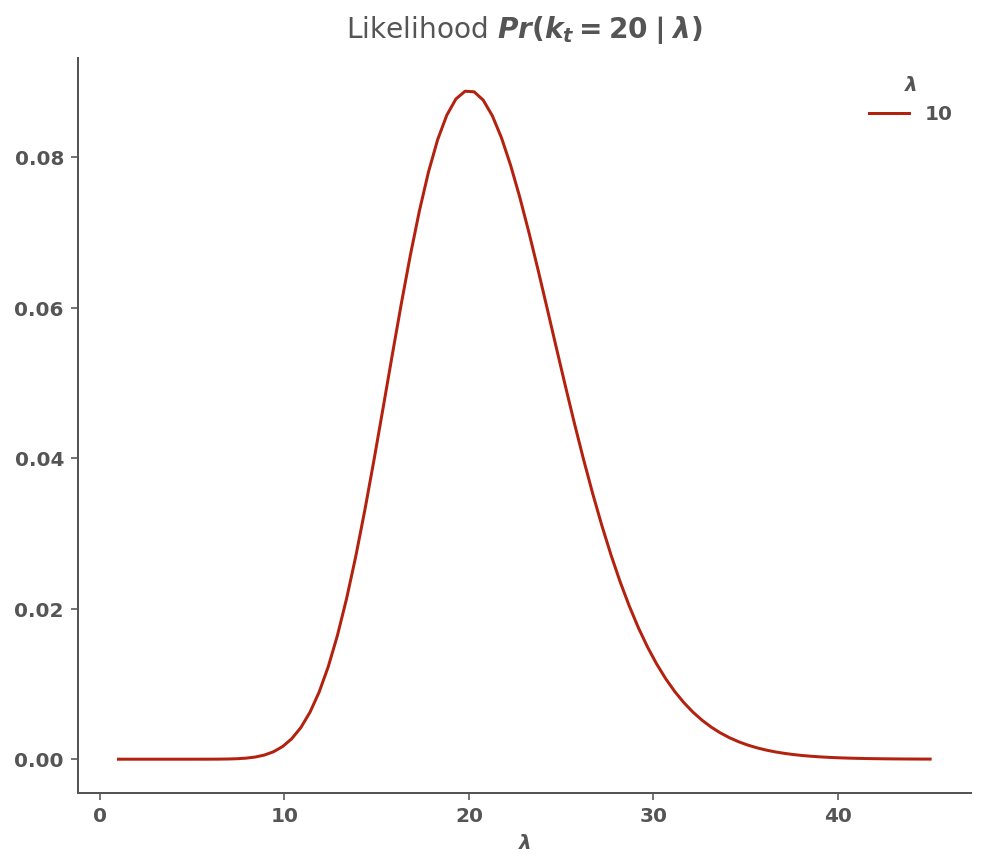

In [6]:
k = 20
lam = np.linspace(1, 45, 90)
likelihood = pd.Series(
    data=sps.poisson.pmf(k, lam),
    index=pd.Index(lam, name='$\lambda$'),
    name='lambda'
)

def plot_it():
    likelihood.plot(
        title=r'Likelihood $Pr\left(k_t=20\mid\lambda\right)$', 
        figsize=(8,6.5)
    )
    plt.legend(title="$\lambda$", labels=lambdas)

plot_it()

This says that if we see 20 cases, the most likely value of $\lambda$ is
(not surprisingly) 20. But we're not certain: it's possible $\lambda$ was 21
or 17 and saw 20 new cases by chance alone. It also says that it's unlikely
$\lambda$ was 40 and we saw 20.

Great. We have $Pr\left(\lambda_t\mid k_t\right)$ which is parameterized
by $\lambda$ but we were looking for $Pr\left(k_t\mid R_t\right)$ which is
parameterized by $R_t$. We need to know the relationship between $\lambda$
and $R_t$



# Connecting $\lambda$ and $R_t$
**The key insight to making this work is to realize there's a connection between $R_t$ and $\lambda$**. 
[The derivation](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185) is beyond the scope of this notebook, but here it is:
\begin{align*}
    \lambda &= k_{t-1}e^{\gamma(R_t-1)}
\end{align*}
where $\gamma$ is the reciprocal of the serial interval 
[about 7 days for COVID-19](https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article). 
Since we know every new case count on the previous day, we can now reformulate
the likelihood function as a Poisson parameterized by fixing $k$ and varying
$R_t$.
\begin{align*}
    \Pr\left(k\mid R_t\right) 
        &= \frac{\lambda^k e^{-\lambda}}{k!}
\end{align*}



# Evaluating the Likelihood Function
To continue our example, let's imagine a sample of new case counts $k$. What
is the likelihood of different values of $R_t$ on each of those days?


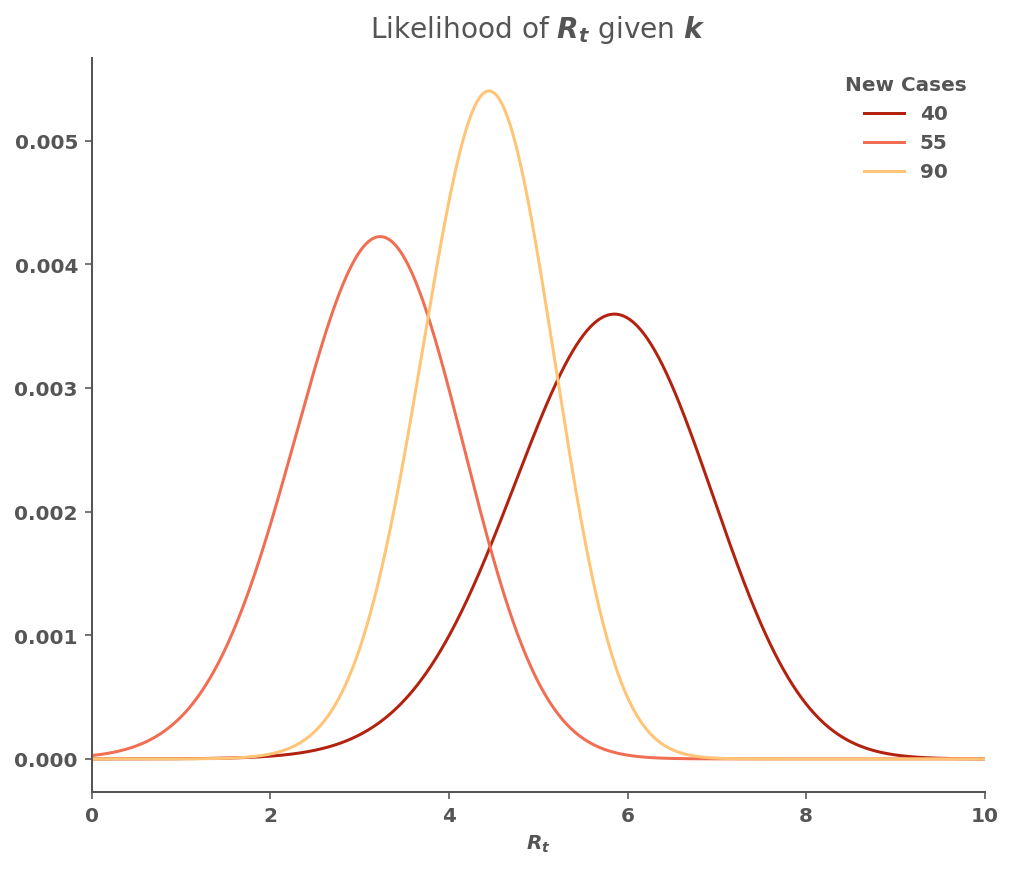

In [7]:
k = np.array([20, 40, 55, 90])

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7

# Map Rt into lambda so we can substitute it into the equation below
# Note that we have N-1 lambdas because on the first day of an outbreak
# you do not know what to expect.
lam = k[:-1] * np.exp(GAMMA * (r_t_range[:, None] - 1))

# Evaluate the likelihood on each day and normalize sum of each day to 1.0
likelihood_r_t = sps.poisson.pmf(k[1:], lam)
likelihood_r_t /= np.sum(likelihood_r_t, axis=0)

def plot_it():
    # Plot it
    ax = pd.DataFrame(
        data = likelihood_r_t,
        index = r_t_range
    ).plot(
        title='Likelihood of $R_t$ given $k$',
        xlim=(0,10),
        figsize=(8,6.5)
    )
    ax.legend(labels=k[1:], title='New Cases')
    ax.set_xlabel('$R_t$');

plot_it()


You can see that each day we have a independent guesses for $R_t$. The goal
is to combine the information we have about previous days with the current
day. To do this, we use Bayes' theorem.



# Performing the Bayesian Update
To perform the Bayesian update, we need to multiply the likelihood by the prior
(which is just the previous day's likelihood without our Gaussian update)
to get the posteriors. Let's do that using the cumulative product of each
successive day:


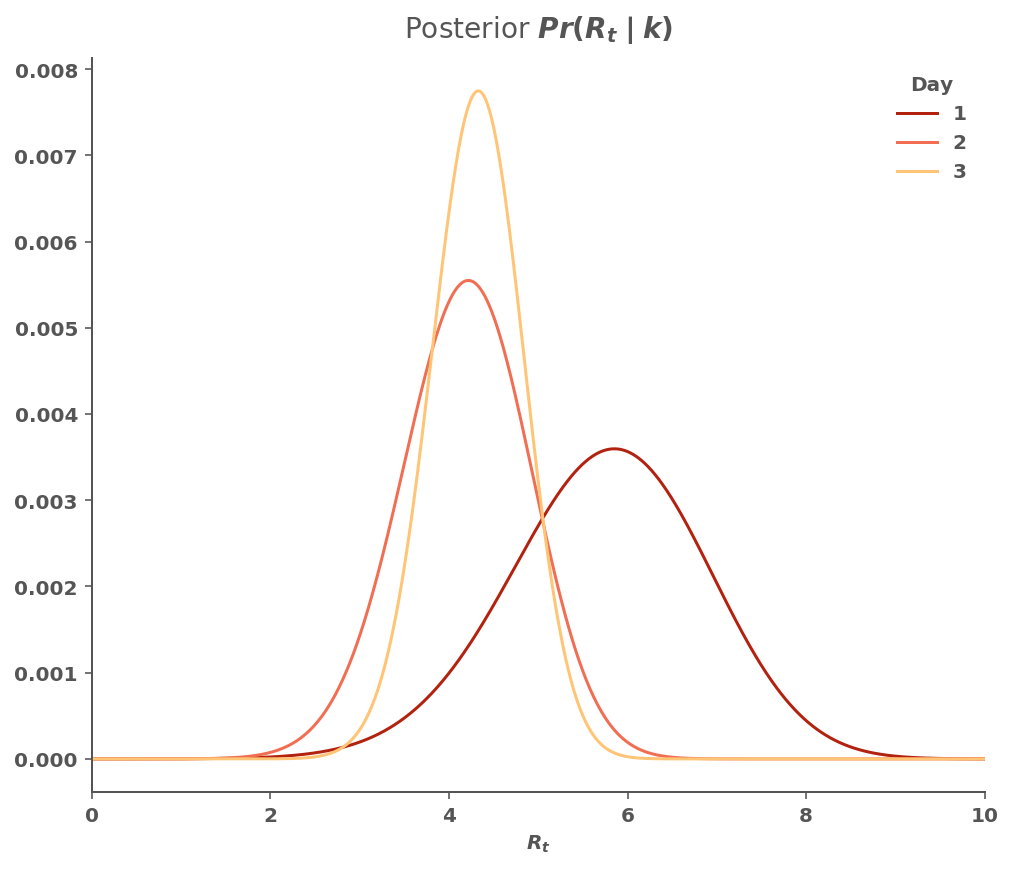

In [8]:
posteriors = likelihood_r_t.cumprod(axis=1)
posteriors = posteriors / np.sum(posteriors, axis=0)

columns = pd.Index(range(1, posteriors.shape[1]+1), name='Day')
posteriors = pd.DataFrame(
    data    = posteriors,
    index   = r_t_range,
    columns = columns
)


def plot_it():
    ax = posteriors.plot(
        title='Posterior $Pr(R_t \mid k)$',
        xlim=(0,10),
        figsize=(8,6.5)
    )
    ax.legend(title='Day')
    ax.set_xlabel('$R_t$');
    
plot_it()


Notice how on Day 1, our posterior matches Day 1's likelihood from
above? That's because we have no information other than that day. However,
when we update the prior using Day 2's information, you can see the curve
has moved left, but not nearly as left as the likelihood for Day 2 from
above. This is because Bayesian updating uses information from both days
and effectively averages the two. Since Day 3's likelihood is in between
the other two, you see a small shift to the right, but more importantly:
a narrower distribution. We're becoming *more* confident in our believes
of the true value of $R_t$.

From these posteriors, we can answer important questions such as :

> ``What is the most likely value of $R_t$ each day?''



In [9]:
most_likely_values = posteriors.idxmax(axis=0)
print(most_likely_values)


Day
1    5.85
2    4.22
3    4.33
dtype: float64


We can also obtain the 
[highest density intervals](https://www.sciencedirect.com/topics/mathematics/highest-density-interval)
for $R_t$:


In [10]:
hdi = highest_density_interval(posteriors, debug=True)
print( f'.\n{hdi.tail()}' )


.
     Low_90  High_90
Day                 
1      3.89     7.55
2      2.96     5.33
3      3.42     5.12


Finally, we can plot both the most likely values for $R_t$ and the HDIs over
time. This is the most useful representation as it shows how our beliefs
change with every day.


<Figure size 576x468 with 0 Axes>

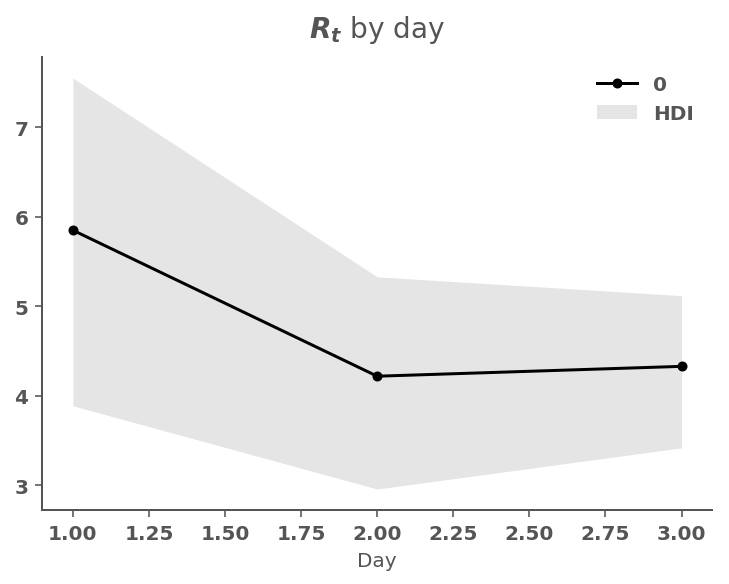

In [11]:
def plot_it():
    # need a pd.DataFrame here
    most_likely = pd.DataFrame(
        most_likely_values
    )
    fig = plt.figure(figsize=(8, 6.5))
    ax = most_likely.plot(
        marker='o',
        label='Most Likely',
        title=f'$R_t$ by day',
        c='k',
        markersize=4,
    )
    ax.fill_between(
        hdi.index,
        hdi['Low_90'],
        hdi['High_90'],
        color='k',
        alpha=.1,
        lw=0,
        label='HDI'
    )
    ax.legend();

plot_it()

We can see that the most likely value of $R_t$ changes with time and the
highest-density interval narrows as we become more sure of the true value of
$R_t$ over time. Note that since we only had four days of history, I did not
apply the process to this sample. Next, however, we'll turn to a real-world
application where this process is necessary.



# Real-World Application to US Data
## Setup
Load US state case data from [CovidTracking.com](https://covidtracking.com):


In [12]:
url = 'https://covidtracking.com/api/v1/states/daily.csv'

states = pd.read_csv(
    url,
    usecols=['date', 'state', 'positive'],
    parse_dates=['date'],
    index_col=['state', 'date'],
    squeeze=True
).sort_index()


In [13]:
states.shape

(2985,)

Taking a look at the state, we need to start the analysis when there are
a consistent number of cases each day. Find the last zero new case day and
start on the day after that.

Also, case reporting is very erratic based on testing backlogs, etc. To get
the best view of the 'true' data we can, I've applied a gaussian filter to
the time series. This is obviously an arbitrary choice, but you'd imagine
the real world process is not nearly as stochastic as the actual reporting.


In [14]:
state_name = 'NY'

cases = states.xs(state_name).rename(f'{state_name} cases')
original, smoothed = prepare_cases(cases)


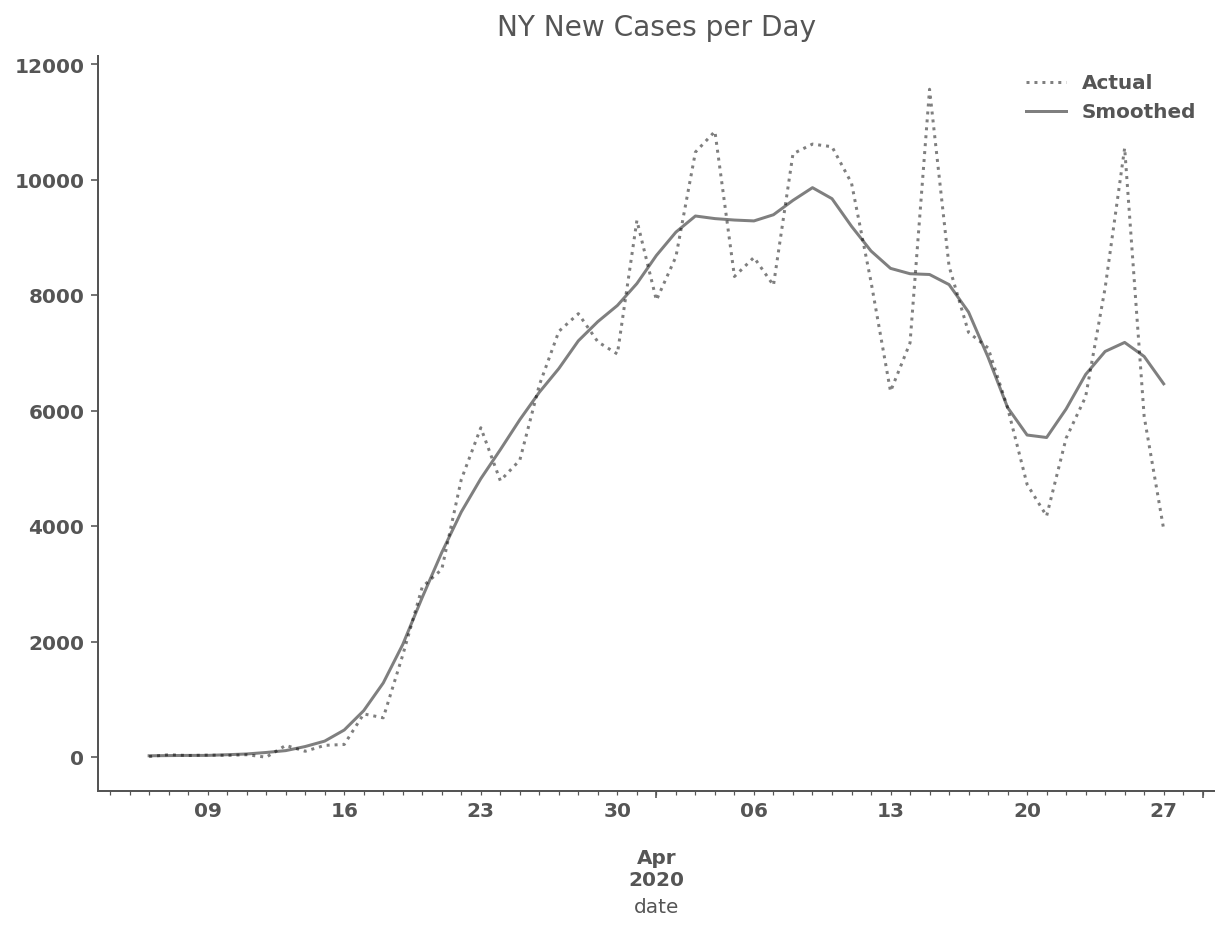

In [15]:
def plot_it():
    df_o = make_plottable_df(original, 'Actual')
    df_s = make_plottable_df(smoothed, 'Smoothed')
    df   = pd.concat([df_o, df_s], axis=1)
    fig, ax = plt.subplots()
    for cn in df.keys(): df[cn].plot(
        ax=ax,
        c='k',
        linestyle = ':' if cn == 'Actual' else '-',
        alpha=.5,
        title=f"{state_name} New Cases per Day",
        legend=True,
        figsize=(10, 6.5)
    )
    ax.get_figure().set_facecolor('w')

plot_it()

## Running the Algorithm
### Choosing the Gaussian $\sigma$ for $\Pr(R_t\mid R_{t-1})$
Note: you can safely skip this section if you trust that we chose the right
value of $\sigma$ for the process below. Otherwise, read on.  

The original approach simply selects yesterday's posterior as today's
prior. While intuitive, doing so doesn't allow for our belief that the value
of $R_t$ has likely changed from yesterday. To allow for that change, we
apply Gaussian noise to the prior distribution with some standard deviation
$\sigma$. The higher $\sigma$ the more noise and the more we will expect
the value of $R_t$ to drift each day. Interestingly, applying noise on
noise iteratively means that there will be a natural decay of distant
posteriors. This approach has a similar effect of windowing, but is more
robust and doesn't arbitrarily forget posteriors after a certain time like
my previous approach. Specifically, windowing computed a fixed $R_t$ at
each time $t$ that explained the surrounding $w$ days of cases, while the
new approach computes a series of $R_t$ values that explains all the cases,
assuming that $R_t$ fluctuates by about $\sigma$ each day.

However, there's still an arbitrary choice: what should $\sigma$ be? Adam
Lerer pointed out that we can use the process of maximum likelihood to inform
our choice. Here's how it works:

Maximum likelihood says that we'd like to choose a $\sigma$ that maximizes
the likelihood of seeing our data $k$: $P(k|\sigma)$. Since $\sigma$ is a
fixed value, let's leave it out of the notation, so we're trying to maximize
$P(k)$ over all choices of $\sigma$.
 
Since $\Pr(k)=P(k_0,k_1,\ldots,k_t)=\Pr(k_0)P(k_1)\ldots \Pr(k_t)$ we need to
define $\Pr(k_t)$. It turns out this is the denominator of Bayes rule:
\begin{align*}
    \Pr(R_t \mid k_t) &= 
        \frac{\Pr(k_t\mid R_t)\Pr(R_t)}{\Pr(k_t)}
\end{align*}
To calculate it, we notice that the numerator is actually just the joint
distribution of $k$ and $R$:
\begin{align*}
    \Pr(k_t,R_t) &=  
        \Pr(k_t \mid R_t)\Pr(R_t) 
\end{align*}
We can marginalize the distribution over $R_t$ to get $\Pr(k_t)$:
\begin{align*}
    \Pr(k_t) &= \sum_{R_{t}}{\Pr(k_t \mid R_t)\Pr(R_t)} 
\end{align*}
So, if we sum the distribution of the numerator over all values of $R_t$,
we get $\Pr(k_t)$. And since we're calculating that anyway as we're calculating
the posterior, we'll just keep track of it separately.

Since we're looking for the value of $\sigma$ that maximizes $\Pr(k)$ overall,
we actually want to maximize:
\begin{align*}
    \prod_{t,i}{p(k_{ti})}
\end{align*}
where $t$ are all times and $i$ is each state.

Since we're multiplying lots of tiny probabilities together, it can be
easier (and less error-prone) to take the $\log$ of the values and add them
together. Remember that $\log{ab}=\log{a}+\log{b}$. And since logarithms
are monotonically increasing, maximizing the sum of the $\log$ of the
probabilities is the same as maximizing the product of the non-logarithmic
probabilities for any choice of $\sigma$.


## Function for Calculating the Posteriors
To calculate the posteriors we follow these steps:

1. Calculate $\lambda$, the expected arrival rate for every day's poisson
   process;
2. Calculate each day's likelihood distribution over all possible values
   of $R_t$;
3. Calculate the process matrix based on the value of $\sigma$ we discussed
   above;
4. Calculate our initial prior because our first day does not have a previous
   day from which to take the posterior
    - Based on [info from the CDC](https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article)
      we will choose a Gamma with mean 7.
5. Loop from day 1 to the end, doing the following:
    - Calculate the prior by applying the Gaussian to yesterday's prior.
    - Apply Bayes' rule by multiplying this prior and the likelihood we calculated in step 2.
    - Divide by the probability of the data (also Bayes' rule)



In [16]:
# Note that we're fixing sigma to a value just for the example
posteriors, log_likelihood = get_posteriors(smoothed, sigma=.25, gamma=GAMMA)


## The Result
Below you can see every day (row) of the posterior distribution plotted
simultaneously. The posteriors start without much confidence (wide) and
become progressively more confident (narrower) about the true value of $R_t$.


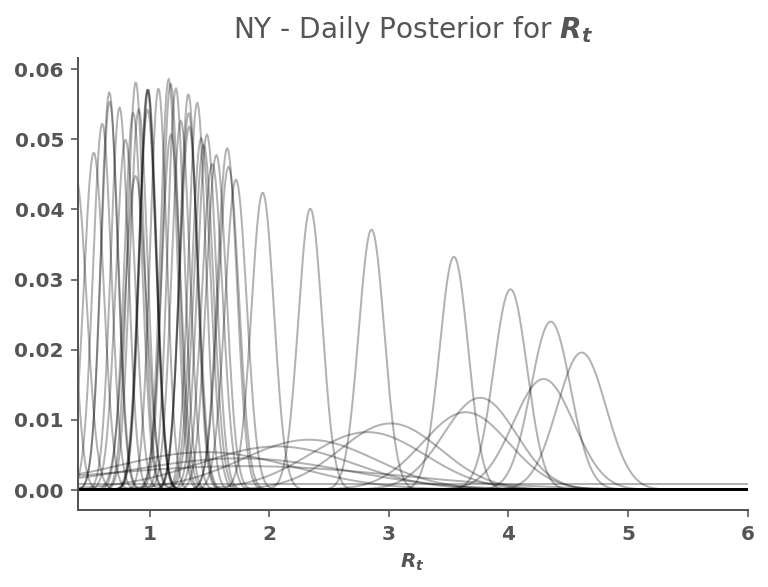

In [17]:
def plot_it():
    ax = posteriors.plot(
        title=f'{state_name} - Daily Posterior for $R_t$',
        legend=False, 
        lw=1,
        c='k',
        alpha=.3,
        xlim=(0.4,6)
    )
    ax.set_xlabel('$R_t$') 
    
plot_it()

## Plotting in the Time Domain with Credible Intervals
Since our results include uncertainty, we'd like to be able to view the
most likely value of $R_t$ along with its highest-density interval.


In [18]:
hdis = highest_density_interval(posteriors, p=.9)
most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)
print( f'.\n{result.tail()}' )


.
              ML  Low_90  High_90
date                             
2020-04-23  1.65    1.51     1.78
2020-04-24  1.43    1.27     1.54
2020-04-25  1.18    1.04     1.30
2020-04-26  0.80    0.64     0.91
2020-04-27  0.53    0.37     0.65


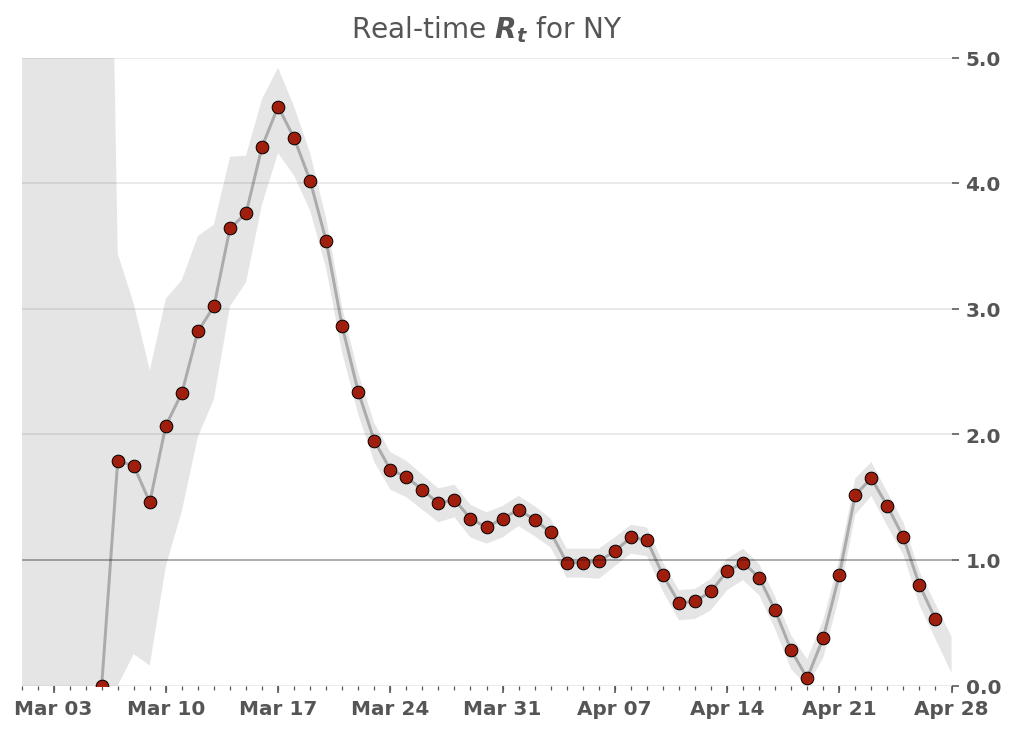

In [19]:
def plot_it():
    fig, ax = plt.subplots(figsize=(600/72,400/72))
    plot_rt(result, ax, state_name, fig)
    ax.set_title(f'Real-time $R_t$ for {state_name}')
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    
plot_it()


## Choosing the optimal $\sigma$
In the previous section we described choosing an optimal $\sigma$, but we
just assumed a value. But now that we can evaluate each state with any sigma,
we have the tools for choosing the optimal $\sigma$.

Above we said we'd choose the value of $\sigma$ that maximizes the likelihood
of the data $P(k)$. Since we don't want to overfit on any one state, we choose
the sigma that maximizes $P(k)$ over every state. To do this, we add up all
the log likelihoods per state for each value of sigma then choose the maximum.

Note: this takes a while!



In [20]:
states.loc[('MA', pd.Timestamp('2020-04-20'))] = 39643
print( f".\n{states.xs('MA').diff().tail()}" )


.
date
2020-04-23    3079.0
2020-04-24    2977.0
2020-04-25    2379.0
2020-04-26    1590.0
2020-04-27    1524.0
Name: positive, dtype: float64


In [22]:
sigmas = np.linspace(1/20, 1, 20)

targets = ~states.index.get_level_values('state').isin(FILTERED_REGION_CODES)
states_to_process = states.loc[targets]

if not 'results' in locals() or not len(results):
    results = {}
    for state_name, cases in states_to_process.groupby(level='state'):
        print(state_name)
        new, smoothed = prepare_cases(cases, cutoff=25)
        if len(smoothed) == 0:
            new, smoothed = prepare_cases(cases, cutoff=10)
        result = {}
        # Holds all posteriors with every given value of sigma
        result['posteriors'] = []
        # Holds the log likelihood across all k for each value of sigma
        result['log_likelihoods'] = []
        for sigma in sigmas:
            posteriors, log_likelihood = get_posteriors(smoothed, sigma=sigma)
            result['posteriors'].append(posteriors)
            result['log_likelihoods'].append(log_likelihood)
        # Store all results keyed off of state name
        results[state_name] = result

print('Done.')


Done.


Now that we have all the log likelihoods, we can sum for each value of sigma
across states, graph it, then choose the maximum.

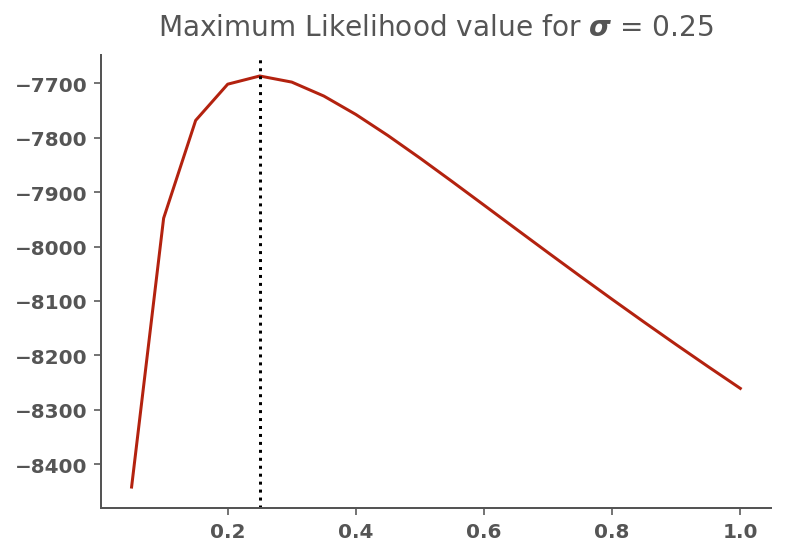

In [23]:
# Each index of this array holds the total of the log likelihoods for
# the corresponding index of the sigmas array.
total_log_likelihoods = np.zeros_like(sigmas)

# Loop through each state's results and add the log likelihoods to the running total.
for state_name, result in results.items():
    total_log_likelihoods += result['log_likelihoods']

# Select the index with the largest log likelihood total
max_likelihood_index = total_log_likelihoods.argmax()

# Select the value that has the highest log likelihood
sigma = sigmas[max_likelihood_index]
def plot_it():
    fig, ax = plt.subplots()
    ax.set_title(f"Maximum Likelihood value for $\sigma$ = {sigma:.2f}");
    ax.plot(sigmas, total_log_likelihoods)
    ax.axvline(sigma, color='k', linestyle=":")

plot_it()


## Compile Final Results
Given that we've selected the optimal $\sigma$, let's grab the precalculated
posterior corresponding to that value of $\sigma$ for each state. Let's also
calculate the 90% and 50% highest density intervals (this takes a little
while) and also the most likely value.



In [25]:
if not 'final_results' in locals() or final_results is None:
    final_results = None

    for state_name, result in results.items():
        print(f'{state_name} ')
        posteriors = result['posteriors'][max_likelihood_index]
        # p = 0.90 fails for CT...
        hdis_90 = highest_density_interval(posteriors, p=.90)
        hdis_50 = highest_density_interval(posteriors, p=.5)
        most_likely = posteriors.idxmax().rename('ML')
        result = pd.concat([most_likely, hdis_90, hdis_50], axis=1)
        if final_results is None:
            final_results = result
        else:
            final_results = pd.concat([final_results, result])

print('Done.')


Done.


Now that we have all the log likelihoods, we can sum for each value of sigma
across states, graph it, then choose the maximum.


## Plot All US States


AK
AL
AR
AZ
CA
CO
CT
DC
DE
FL
GA
HI
IA
ID
IL
IN
KS
KY
LA
MA
MD
ME
MI
MN
MO
MS
MT
NC
ND
NE
NH
NJ
NM
NV
NY
OH
OK
OR
PA
RI
SC
SD
TN
TX
UT
VA
VT
WA
WI
WV
WY


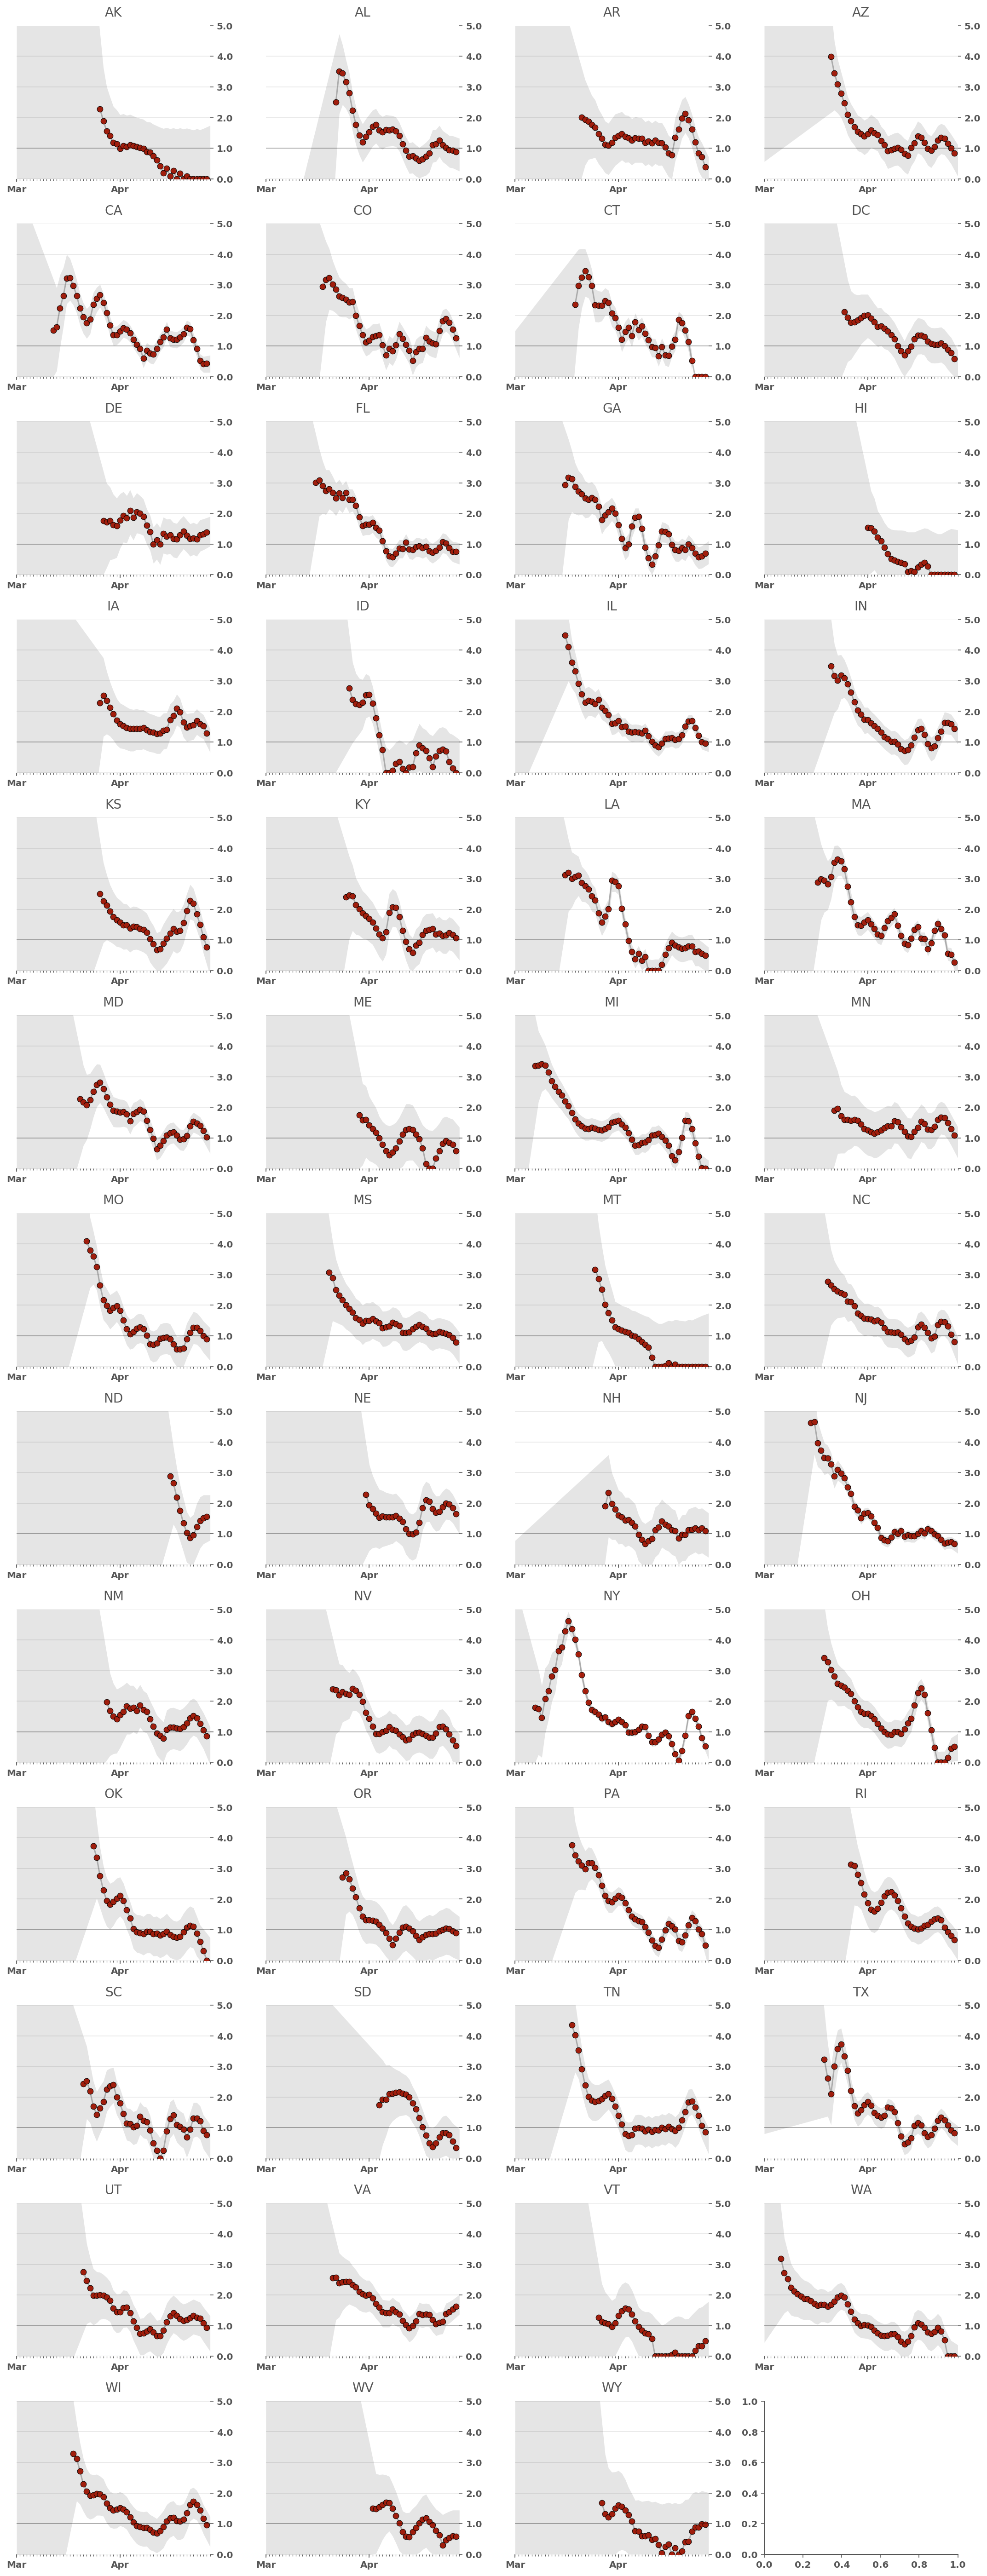

In [26]:
ncols = 4
nrows = int(np.ceil(len(results) / ncols))

def plot_it():
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))
    for i, (state_name, result) in enumerate(final_results.groupby('state')):
        print(state_name)
        plot_rt(result.iloc[1:], axes.flat[i], state_name, fig)
    fig.tight_layout()
    fig.set_facecolor('w')

plot_it()


In [40]:
if RUN_WITH_DROPLEVEL:
    # Since we now use a uniform prior, the first datapoint is pretty bogus, so just truncating it here
    final_results = final_results.groupby('state').apply(lambda x: x.iloc[1:].droplevel(0))


# Export Data to CSV

Export the data:


In [41]:
final_results.to_csv('rt.csv')


In [42]:
# As of 4/12
no_lockdown = [
    'North Dakota', 'ND',
    'South Dakota', 'SD',
    'Nebraska', 'NE',
    'Iowa', 'IA',
    'Arkansas','AR'
]
partial_lockdown = [
    'Utah', 'UT',
    'Wyoming', 'WY',
    'Oklahoma', 'OK',
    'Massachusetts', 'MA'
]

FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]


/home/tharte/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


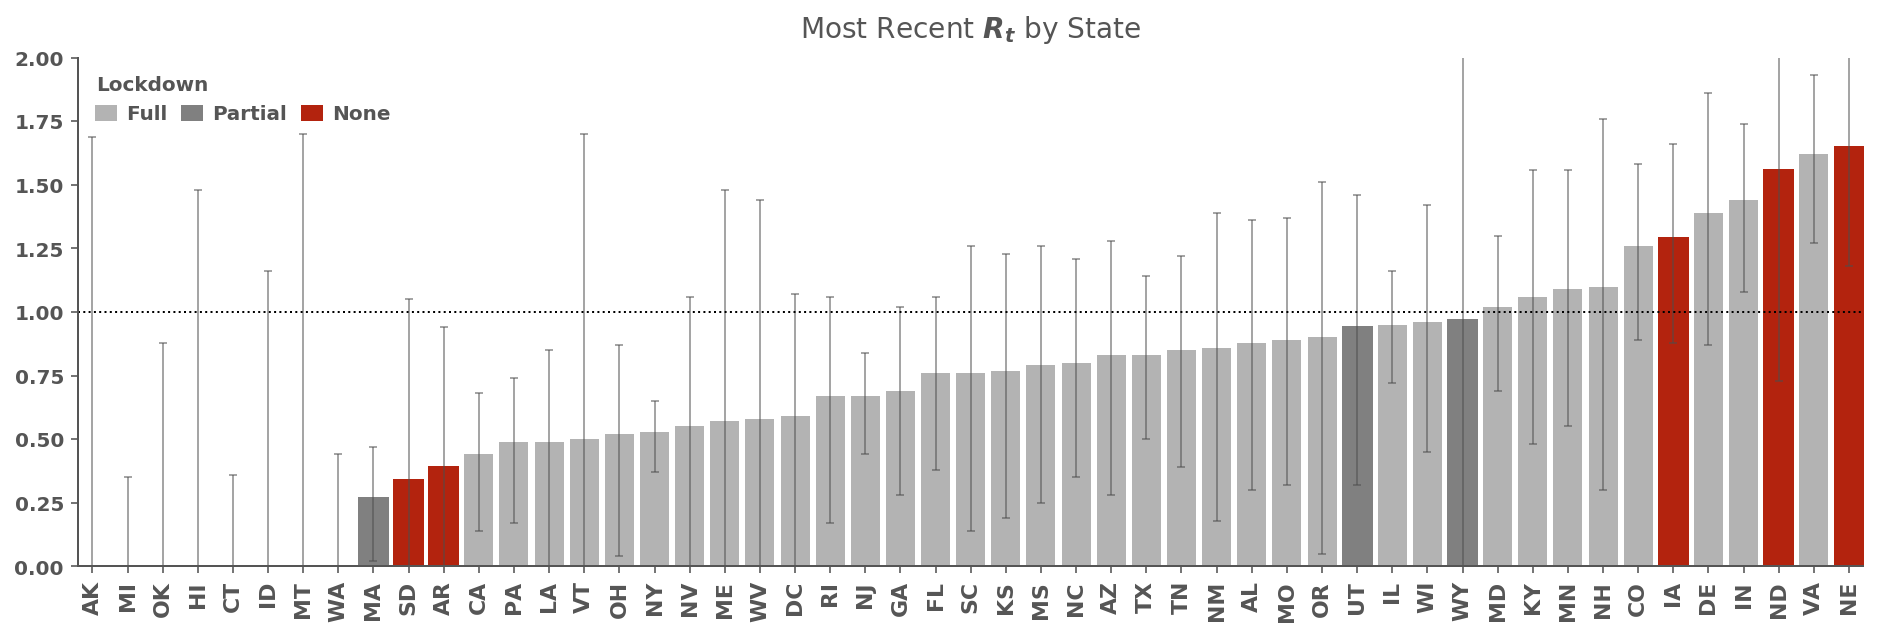

In [30]:
filtered = final_results.index.get_level_values(0).isin(FILTERED_REGION_CODES)
mr = final_results.loc[~filtered].groupby(level=0)[['ML', 'High_90', 'Low_90']].last()

def plot_it():
    mr.sort_values('ML', inplace=True)
    plot_standings(mr, figsize=(16, 4.5));

plot_it()

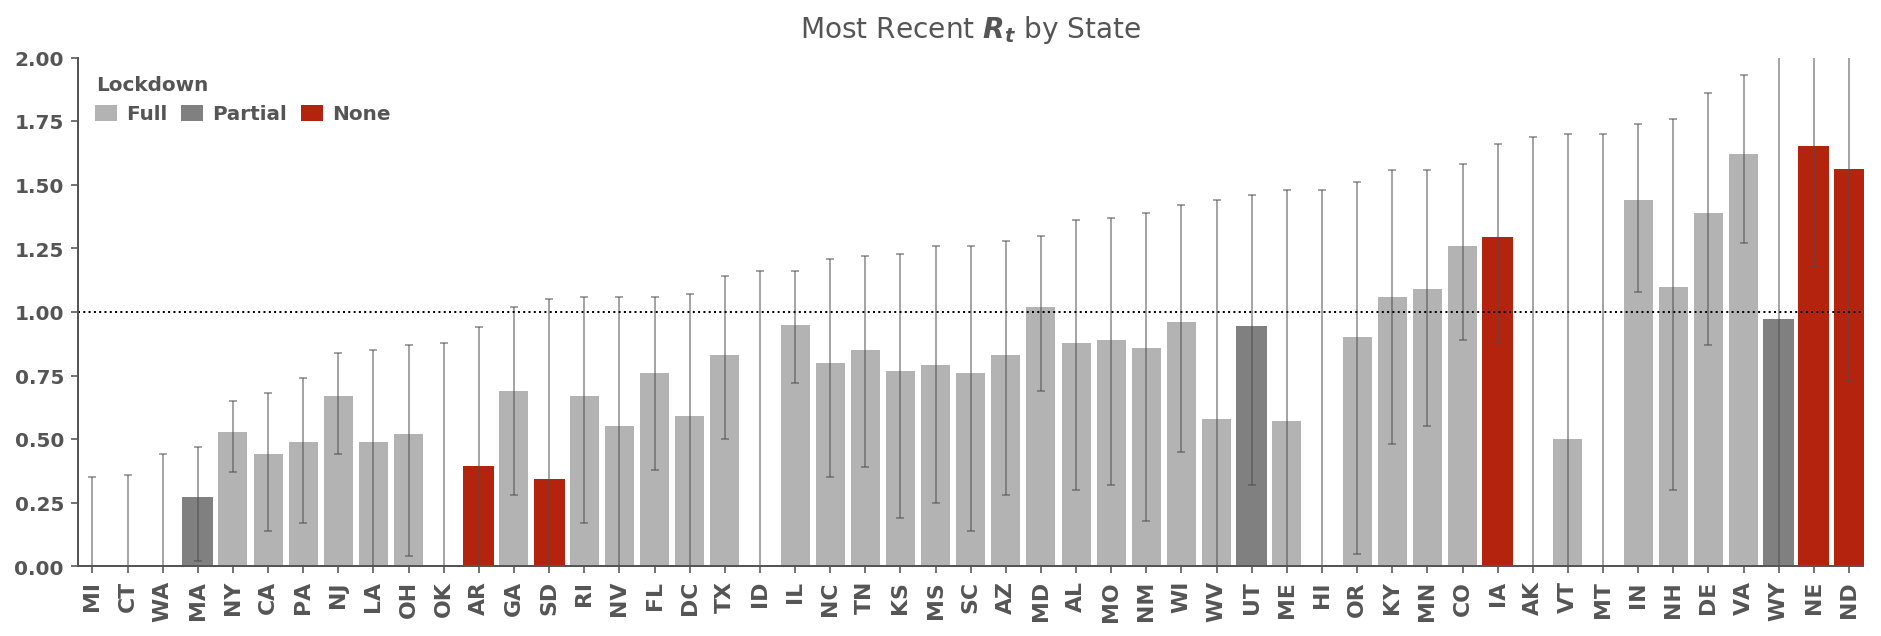

In [31]:
def plot_it():
    mr.sort_values('High_90', inplace=True)
    plot_standings(mr, figsize=(16, 4.5));
    
plot_it()


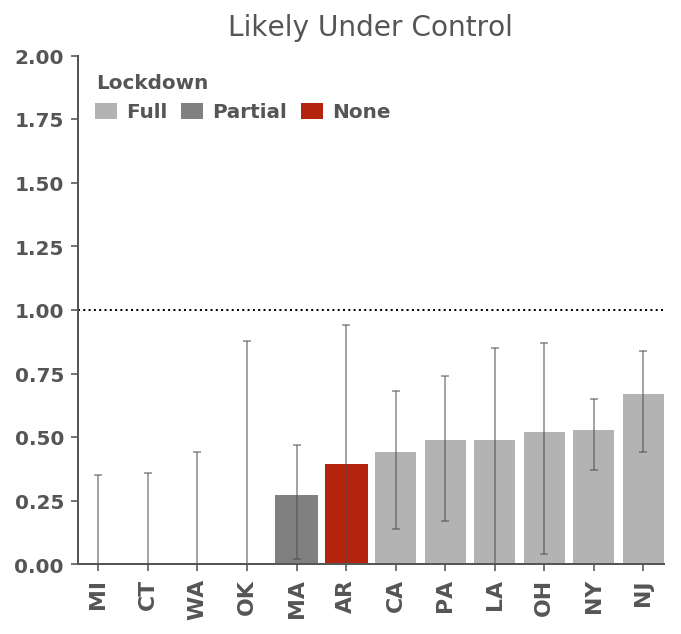

In [33]:
def plot_it():
    show = mr[mr.High_90.le(1)].sort_values('ML')
    fig, ax = plot_standings(show, figsize=(5.25,4.5), title='Likely Under Control');
    
plot_it()

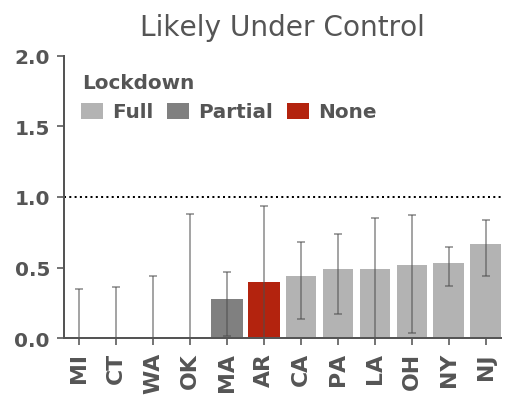

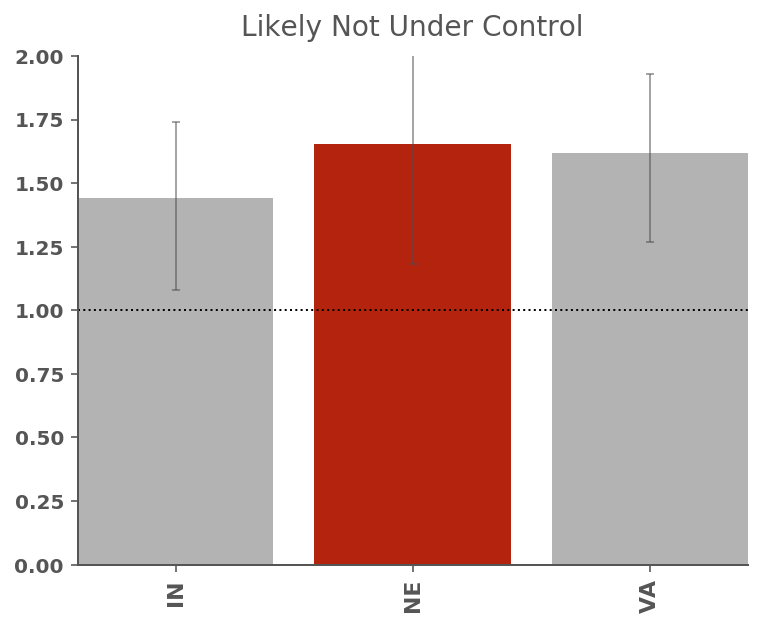

In [34]:
show = mr[mr.High_90.le(1)].sort_values('ML')
fig, ax = plot_standings(show, title='Likely Under Control');

def plot_it():
    show = mr[mr.Low_90.ge(1.0)].sort_values('Low_90')
    fig, ax = plot_standings(show, figsize=(6, 4.5), title='Likely Not Under Control');
    ax.get_legend().remove()

plot_it()


# Build: Python packages

In [35]:
pd.show_versions()


INSTALLED VERSIONS
------------------
commit: None
python: 3.7.1.final.0
python-bits: 64
OS: Linux
OS-release: 5.3.0-46-generic
machine: x86_64
processor: x86_64
byteorder: little
LC_ALL: None
LANG: en_US.UTF-8
LOCALE: en_US.UTF-8

pandas: 0.23.4
pytest: 4.0.2
pip: 18.1
setuptools: 40.6.3
Cython: 0.29.2
numpy: 1.15.4
scipy: 1.1.0
pyarrow: None
xarray: None
IPython: 7.2.0
sphinx: 1.8.2
patsy: 0.5.1
dateutil: 2.7.5
pytz: 2018.7
blosc: None
bottleneck: 1.2.1
tables: 3.4.4
numexpr: 2.6.8
feather: None
matplotlib: 3.0.2
openpyxl: 2.5.12
xlrd: 1.2.0
xlwt: 1.3.0
xlsxwriter: 1.1.2
lxml: 4.2.5
bs4: 4.6.3
html5lib: 1.0.1
sqlalchemy: 1.2.15
pymysql: None
psycopg2: None
jinja2: 2.10
s3fs: None
fastparquet: None
pandas_gbq: None
pandas_datareader: None
